In [1]:
!git clone https://github.com/MisbahKhan0009/CSE445-G4.git

Cloning into 'CSE445-G4'...
remote: Enumerating objects: 568, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 568 (delta 12), reused 4 (delta 0), pack-reused 527 (from 3)
Receiving objects: 100% (568/568), 551.24 MiB | 32.37 MiB/s, done.
Resolving deltas: 100% (32/32), done.
Updating files: 100% (220/220), done.


In [2]:
!pip install -q torch torchvision numpy pillow scikit-learn scikit-image matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 71.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 62.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 64.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

Low-res image shape: torch.Size([3, 128, 128])
High-res image shape: torch.Size([3, 512, 512])
SRModel(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): ReLU()
    (2): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (3): ReLU()
    (4): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU()
    (6): ConvTranspose2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (7): ReLU()
    (8): ConvTranspose2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(32, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (11): Sigmoid()
  )
)
Epoch 1/200, Loss: 0.0959, Val Loss: 0.0979, MAE: 0.2703, Val MAE: 0.2779
Epoch 2/200, Loss: 0.0891, Val Loss: 0.0824, MAE: 0.2608, Val MAE: 0.2551
Epoch 3/200, Loss: 0.0830, Val Loss: 0.0759, MAE: 0.2488, Val MAE: 0.2449
Epoch 4/200, Loss: 0.0694, Val L

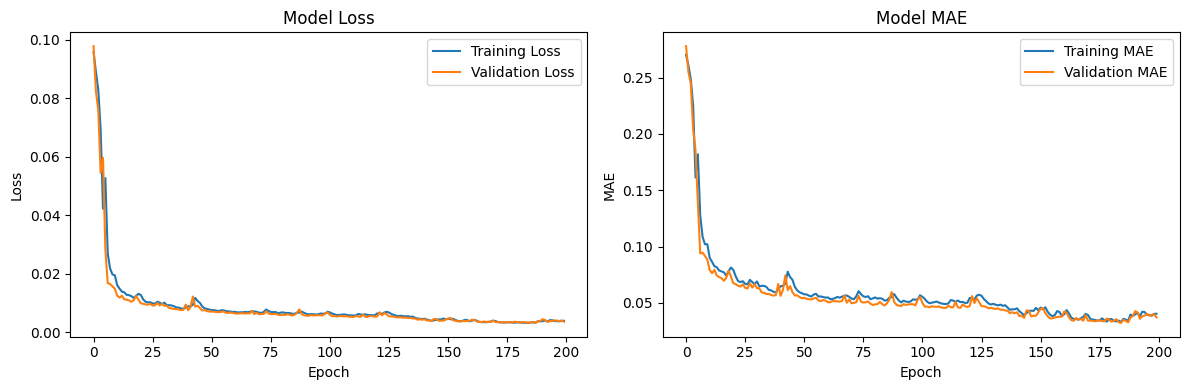

Model saved to super_resolution_model_200epoch.pth
Evaluating test images...


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [3]:
# Cell 1: Imports
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
import pickle

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Cell 2: Load Images Function
def load_images(hr_path, lr_path, target_lr_size=(128, 128)):
    hr_images = []
    lr_images = []

    for i in range(1, 101):
        hr_file = os.path.join(hr_path, f'HR{i:03d}.jpg')
        lr_file = os.path.join(lr_path, f'LR{i:03d}.jpg')

        if os.path.exists(hr_file) and os.path.exists(lr_file):
            lr_img = np.array(Image.open(lr_file).resize(target_lr_size)) / 255.0
            hr_size = (target_lr_size[0] * 4, target_lr_size[1] * 4)
            hr_img = np.array(Image.open(hr_file).resize(hr_size)) / 255.0

            hr_images.append(hr_img)
            lr_images.append(lr_img)

    return np.array(hr_images), np.array(lr_images)

# Load images
hr_path = '/content/CSE445-G4/data/highRes'
lr_path = '/content/CSE445-G4/data/lowRes'
hr_images, lr_images = load_images(hr_path, lr_path)

# Convert to PyTorch tensors and adjust dimensions (N, C, H, W)
hr_images = torch.tensor(hr_images, dtype=torch.float32).permute(0, 3, 1, 2)
lr_images = torch.tensor(lr_images, dtype=torch.float32).permute(0, 3, 1, 2)

# Print shapes
print(f"Low-res image shape: {lr_images[0].shape}")
print(f"High-res image shape: {hr_images[0].shape}")

# Split dataset
lr_train, lr_test, hr_train, hr_test = train_test_split(
    lr_images, hr_images, test_size=0.2, random_state=42
)

# Create DataLoaders
train_dataset = TensorDataset(lr_train, hr_train)
test_dataset = TensorDataset(lr_test, hr_test)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Cell 3: Build Model
class SRModel(nn.Module):
    def __init__(self, input_shape):
        super(SRModel, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(input_shape[0], 64, kernel_size=9, padding=4),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 3, kernel_size=5, padding=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Initialize model
input_shape = lr_images[0].shape  # (C, H, W)
model = SRModel(input_shape).to(device)
optimizer = optim.Adam(model.parameters())
criterion = nn.MSELoss()

# Model summary (approximate)
print(model)

# Cell 4: Train Model
def train_model(model, train_loader, test_loader, epochs=200):
    history = {'loss': [], 'val_loss': [], 'mae': [], 'val_mae': []}

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_mae = 0
        for lr, hr in train_loader:
            lr, hr = lr.to(device), hr.to(device)
            optimizer.zero_grad()
            outputs = model(lr)
            loss = criterion(outputs, hr)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_mae += torch.mean(torch.abs(outputs - hr)).item()

        train_loss /= len(train_loader)
        train_mae /= len(train_loader)

        model.eval()
        val_loss = 0
        val_mae = 0
        with torch.no_grad():
            for lr, hr in test_loader:
                lr, hr = lr.to(device), hr.to(device)
                outputs = model(lr)
                val_loss += criterion(outputs, hr).item()
                val_mae += torch.mean(torch.abs(outputs - hr)).item()

        val_loss /= len(test_loader)
        val_mae /= len(test_loader)

        history['loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['mae'].append(train_mae)
        history['val_mae'].append(val_mae)

        print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, MAE: {train_mae:.4f}, Val MAE: {val_mae:.4f}")

    return history

# Train
history = train_model(model, train_loader, test_loader)

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['mae'], label='Training MAE')
plt.plot(history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

# Save model
torch.save(model.state_dict(), 'super_resolution_model_200epoch.pth')
print("Model saved to super_resolution_model_200epoch.pth")



Evaluating test images...


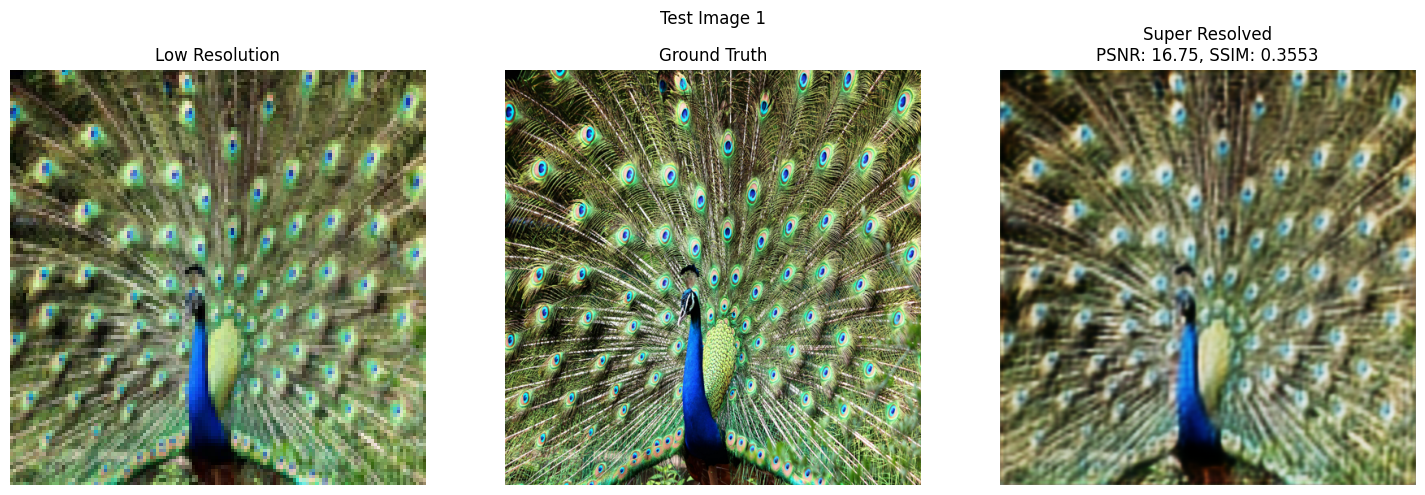

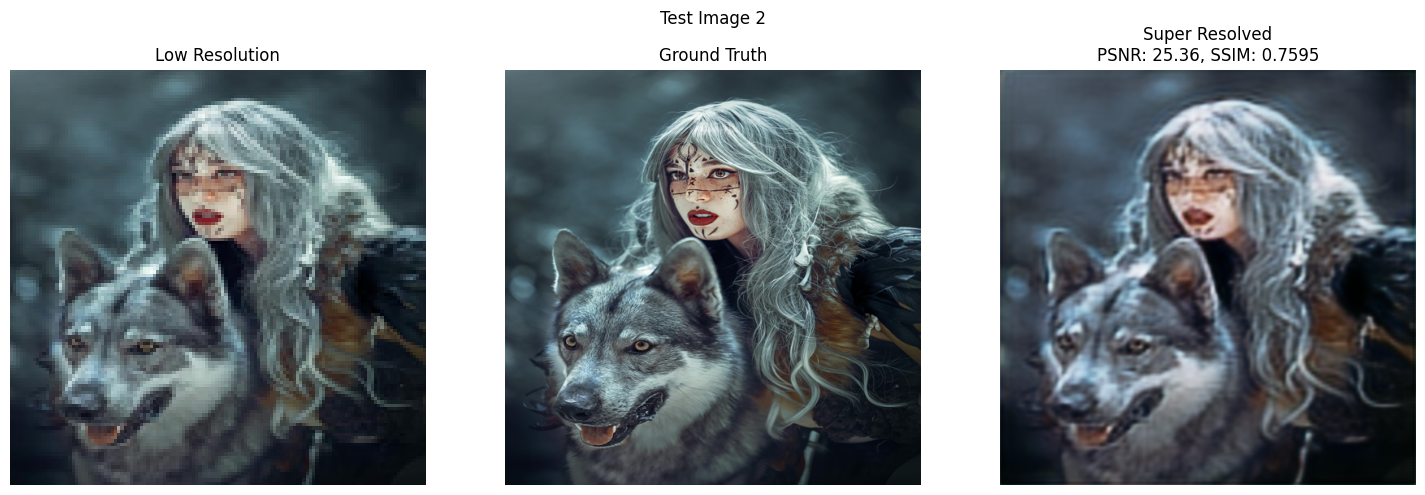

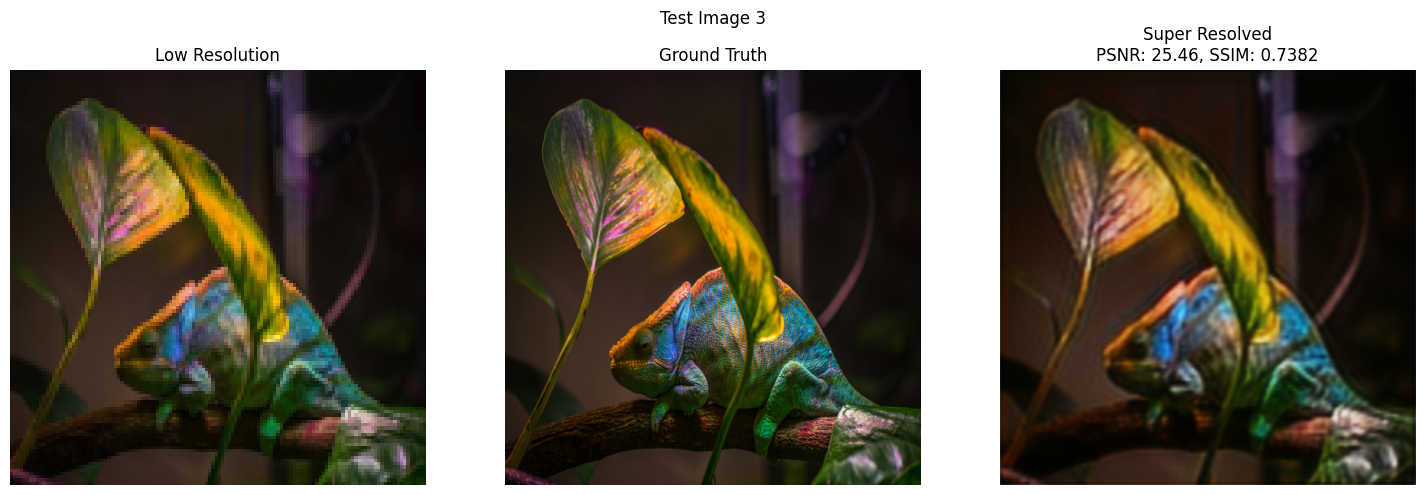

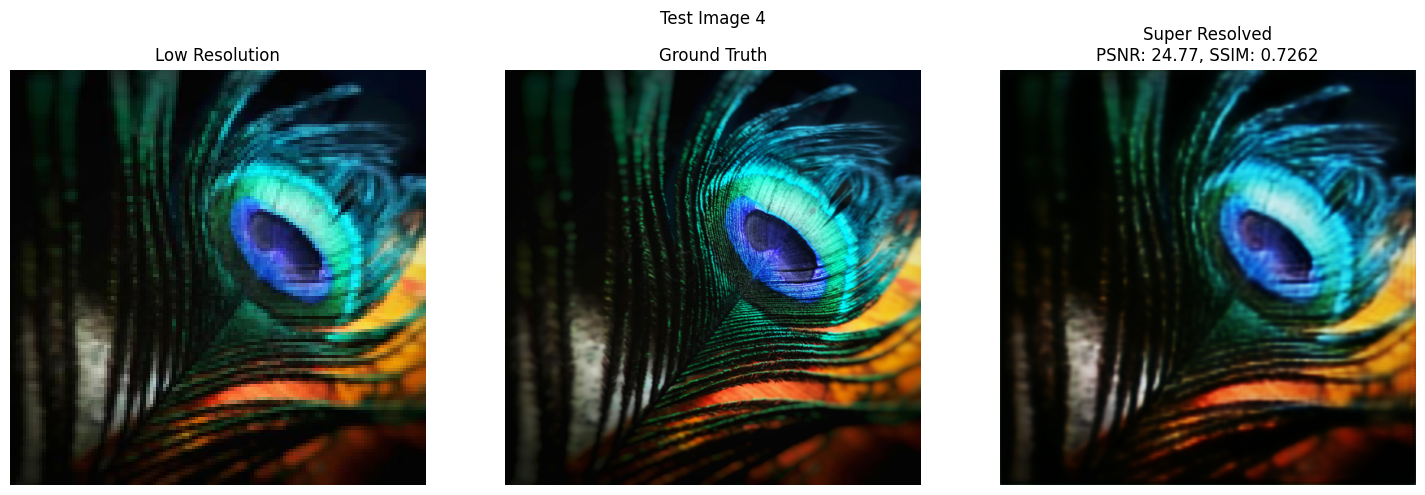

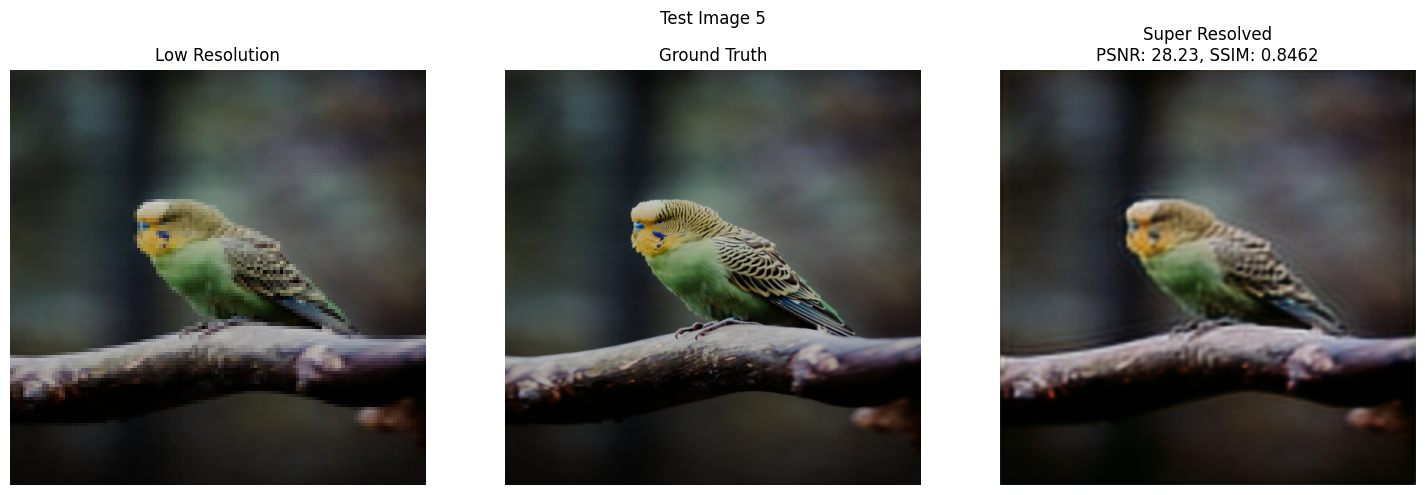


Average PSNR: 24.11 dB
Average SSIM: 0.6851


In [5]:
# Cell 5: Evaluation Function
def evaluate_and_plot(model, lr_img, hr_img, title="Test Image"):
    model.eval()
    lr_img = lr_img.unsqueeze(0).to(device)  # Add batch dimension
    with torch.no_grad():
        sr_img = model(lr_img)[0].cpu().numpy()  # Remove batch dimension

    # Convert to numpy and adjust for metrics
    hr_img_np = hr_img.permute(1, 2, 0).numpy()  # (H, W, C)
    sr_img = sr_img.transpose(1, 2, 0)  # (H, W, C)
    lr_img_np = lr_img.squeeze(0).permute(1, 2, 0).cpu().numpy()  # Move to CPU before numpy

    # Calculate metrics
    psnr_value = psnr(hr_img_np, sr_img, data_range=1.0)
    ssim_value = ssim(hr_img_np, sr_img, data_range=1.0, channel_axis=2, win_size=7)

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(lr_img_np)
    plt.title('Low Resolution')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(hr_img_np)
    plt.title('Ground Truth')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(sr_img)
    plt.title(f'Super Resolved\nPSNR: {psnr_value:.2f}, SSIM: {ssim_value:.4f}')
    plt.axis('off')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

    return psnr_value, ssim_value

# Cell 6: Evaluate Test Images
print("Evaluating test images...")
psnr_values = []
ssim_values = []

for i in range(min(5, len(lr_test))):
    psnr_val, ssim_val = evaluate_and_plot(model, lr_test[i], hr_test[i], f"Test Image {i+1}")
    psnr_values.append(psnr_val)
    ssim_values.append(ssim_val)

print(f"\nAverage PSNR: {np.mean(psnr_values):.2f} dB")
print(f"Average SSIM: {np.mean(ssim_values):.4f}")

In [9]:
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from IPython.display import display, HTML, clear_output
from google.colab import files
import base64
from io import BytesIO
import matplotlib.pyplot as plt
import time
import google.colab.output

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the model
class SRModel(nn.Module):
    def __init__(self, input_shape):
        super(SRModel, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(input_shape[0], 64, kernel_size=9, padding=4),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 3, kernel_size=5, padding=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Load the trained model
input_shape = (3, 128, 128)
model = SRModel(input_shape).to(device)
model.load_state_dict(torch.load('super_resolution_model_200epoch.pth'))
model.eval()

# Function to preprocess uploaded image
def preprocess_image(image, target_size=(128, 128)):
    img = image.resize(target_size)
    img_array = np.array(img) / 255.0
    img_tensor = torch.tensor(img_array, dtype=torch.float32).permute(2, 0, 1)
    print(f"Preprocessed image shape: {img_tensor.shape}")
    return img_tensor

# Function to enhance image
def enhance_image(model, lr_tensor):
    lr_tensor = lr_tensor.unsqueeze(0).to(device)
    with torch.no_grad():
        sr_tensor = model(lr_tensor)[0].cpu()
    print(f"Super-resolved tensor shape: {sr_tensor.shape}")
    sr_img = sr_tensor.permute(1, 2, 0).numpy()
    sr_img = np.clip(sr_img * 255.0, 0, 255).astype(np.uint8)
    print(f"Super-resolved image array shape: {sr_img.shape}, min: {sr_img.min()}, max: {sr_img.max()}")
    sr_pil = Image.fromarray(sr_img)
    sr_pil.save('debug_sr_output.png')
    print("Saved super-resolved image to 'debug_sr_output.png'")
    return sr_pil

# Function to convert image to base64
def image_to_base64(img):
    buffered = BytesIO()
    img.save(buffered, format="PNG")
    img_base64 = base64.b64encode(buffered.getvalue()).decode('utf-8')
    print("Generated base64 string for image")
    return img_base64

# HTML and JavaScript for UI
html_code = """
<div style="text-align: center; padding: 20px;">
    <h2>Super Resolution Image Enhancer</h2>
    <input type="file" id="imageUpload" accept="image/*" style="margin: 10px;">
    <br>
    <button onclick="uploadAndProcess()" style="padding: 10px 20px; font-size: 16px;">Enhance Image</button>
    <div id="output" style="margin-top: 20px;">
        <h3>Results</h3>
        <div style="display: flex; justify-content: center; gap: 20px;">
            <div>
                <h4>Low Resolution Input</h4>
                <img id="lrImage" style="max-width: 256px;"/>
            </div>
            <div>
                <h4>Super Resolved Output</h4>
                <img id="srImage" style="max-width: 512px;"/>
            </div>
        </div>
    </div>
</div>

<script>
function uploadAndProcess() {
    const input = document.getElementById('imageUpload');
    if (input.files.length === 0) {
        alert("Please select an image!");
        return;
    }

    const file = input.files[0];
    const reader = new FileReader();

    reader.onload = function(e) {
        document.getElementById('lrImage').src = e.target.result;
        console.log('Triggering processImage callback');
        google.colab.kernel.invokeFunction('notebook.processImage', [file], {});
    };

    reader.readAsDataURL(file);
}
</script>
"""

# Register callback to process image
def process_image(file):
    print("Callback triggered: Processing image")
    if isinstance(file, dict):
        file_content = next(iter(file.values()))
    else:
        raise ValueError("Expected a dictionary containing file contents")

    file_stream = BytesIO(file_content)
    img = Image.open(file_stream).convert('RGB')
    print(f"Loaded input image size: {img.size}")

    lr_tensor = preprocess_image(img)
    sr_img = enhance_image(model, lr_tensor)

    lr_base64 = image_to_base64(img.resize((128, 128)))
    sr_base64 = image_to_base64(sr_img)

    # Update UI with results
    js_code = f"""
    document.getElementById('lrImage').src = 'data:image/png;base64,{lr_base64}';
    document.getElementById('srImage').src = 'data:image/png;base64,{sr_base64}';
    console.log('UI updated with images');
    """
    display(HTML(f"<script>{js_code}</script>"))

    # Display using matplotlib
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img.resize((128, 128)))
    plt.title('Low Resolution Input')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(sr_img)
    plt.title('Super Resolved Output')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    print("Matplotlib plot displayed")

# Register the callback
google.colab.output.register_callback('notebook.processImage', process_image)

# Display UI and keep cell alive
print("Displaying UI. Upload an image and click 'Enhance Image'.")
clear_output(wait=True)
display(HTML(html_code))

# Keep the cell alive to allow uploads
try:
    while True:
        time.sleep(1)  # Keep cell running to handle callbacks
except KeyboardInterrupt:
    print("Stopped cell execution. UI remains active.")

Stopped cell execution. UI remains active.
Callback triggered: Processing image


In [ ]:
# Install required packages
!pip install fastapi uvicorn python-multipart pillow torch torchvision pyngrok


In [15]:

# Kill any existing ngrok processes
!pkill ngrok

import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from fastapi import FastAPI, File, UploadFile
from fastapi.responses import StreamingResponse
from fastapi.middleware.cors import CORSMiddleware
from io import BytesIO
import uvicorn
from pyngrok import ngrok
import nest_asyncio

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the model (same as previous implementation)
class SRModel(nn.Module):
    def __init__(self, input_shape):
        super(SRModel, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(input_shape[0], 64, kernel_size=9, padding=4),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 3, kernel_size=5, padding=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Initialize FastAPI app
app = FastAPI(title="Super Resolution Image Enhancer")

# Enable CORS
app.add_middleware(
    CORSMiddleware,
    allow_origins=["*"],  # Allow your frontend origin
    allow_credentials=True,
    allow_methods=["*"],  # Allow all methods (GET, POST, etc.)
    allow_headers=["*"],  # Allow all headers
)

# Load the trained model
input_shape = (3, 128, 128)  # Expected input shape: (C, H, W)
model = SRModel(input_shape).to(device)
model.load_state_dict(torch.load('super_resolution_model_200epoch.pth'))
model.eval()

# Function to preprocess uploaded image
def preprocess_image(image, target_size=(128, 128)):
    img = image.resize(target_size)
    img_array = np.array(img) / 255.0
    img_tensor = torch.tensor(img_array, dtype=torch.float32).permute(2, 0, 1)
    print(f"Preprocessed image shape: {img_tensor.shape}")
    return img_tensor

# Function to enhance image
def enhance_image(model, lr_tensor):
    lr_tensor = lr_tensor.unsqueeze(0).to(device)  # Add batch dimension
    with torch.no_grad():
        sr_tensor = model(lr_tensor)[0].cpu()
    sr_img = sr_tensor.permute(1, 2, 0).numpy()
    sr_img = np.clip(sr_img * 255.0, 0, 255).astype(np.uint8)
    print(f"Super-resolved image array shape: {sr_img.shape}, min: {sr_img.min()}, max: {sr_img.max()}")
    return Image.fromarray(sr_img)

# FastAPI endpoint to handle image upload and return super-resolved image
@app.post("/enhance")
async def enhance_image_endpoint(file: UploadFile = File(...)):
    contents = await file.read()
    img = Image.open(BytesIO(contents)).convert('RGB')
    print(f"Received image size: {img.size}")

    lr_tensor = preprocess_image(img)
    sr_img = enhance_image(model, lr_tensor)
    print(f"Generated super-resolved image size: {sr_img.size}")

    output_buffer = BytesIO()
    sr_img.save(output_buffer, format="PNG")
    output_buffer.seek(0)

    return StreamingResponse(output_buffer, media_type="image/png")

# Set up ngrok and run the server
def run_server():
    nest_asyncio.apply()

    # Set ngrok auth token
    ngrok.set_auth_token("2owD7wYZFV3m4i6Lfav6hYkKGFz_59T3nd2QpgfW5nMXTkXQA")  # Replace with your ngrok token

    # Ensure no existing tunnels are open
    try:
        tunnels = ngrok.get_tunnels()
        for tunnel in tunnels:
            ngrok.disconnect(tunnel.public_url)
    except:
        pass

    # Start ngrok tunnel
    public_url = ngrok.connect(8000)
    print(f"FastAPI server running at: {public_url}")

    # Run the FastAPI server
    uvicorn.run(app, host="0.0.0.0", port=8000)

if __name__ == "__main__":
    run_server()

ERROR:asyncio:Task exception was never retrieved
future: <Task finished name='Task-27' coro=<Server.serve() done, defined at /usr/local/lib/python3.11/dist-packages/uvicorn/server.py:68> exception=KeyboardInterrupt()>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/uvicorn/main.py", line 580, in run
    server.run()
  File "/usr/local/lib/python3.11/dist-packages/uvicorn/server.py", line 66, in run
    return asyncio.run(self.serve(sockets=sockets))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/nest_asyncio.py", line 30, in run
    return loop.run_until_complete(task)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/nest_asyncio.py", line 92, in run_until_complete
    self._run_once()
  File "/usr/local/lib/python3.11/dist-packages/nest_asyncio.py", line 133, in _run_once
    handle._run()
  File "/usr/lib/python3.11/asyncio/events.py", line 84, in _run
    s

FastAPI server running at: NgrokTunnel: "https://99b3-34-82-5-194.ngrok-free.app" -> "http://localhost:8000"


INFO:     Started server process [374]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


Received image size: (300, 300)
Preprocessed image shape: torch.Size([3, 128, 128])
Super-resolved image array shape: (512, 512, 3), min: 0, max: 232
Generated super-resolved image size: (512, 512)
INFO:     2a09:bac5:485:18d2::279:3b:0 - "POST /enhance HTTP/1.1" 200 OK
Received image size: (300, 300)
Preprocessed image shape: torch.Size([3, 128, 128])
Super-resolved image array shape: (512, 512, 3), min: 0, max: 232
Generated super-resolved image size: (512, 512)
INFO:     2a09:bac5:485:18d2::279:3b:0 - "POST /enhance HTTP/1.1" 200 OK


INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [374]
